In [2]:
import common
import importlib
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import socket

# Show all columns and rows in a dataframe
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

base_path = "/home/per/workspace/sortledton/src/figures/"

## Analytics

In [5]:
# graphalytics inserts
sortledton_block_sizeonly = "num_threads_read == 0 and (hostname == 'scyper21' or hostname == 'scyper22') and library == 'sortledton.3' and graph in ('graph500-22', 'graph500-24', 'graph500-26', 'uniform-24')"


data = common.import_gfe("view_graphalytics_inserts").query(sortledton_block_sizeonly).copy() # data from the experiments
data["build_frequency"].fillna(pd.Timedelta(0), inplace=True) # replace NaT with 0, otherwise the records are ignored in the group by

data = data.groupby(["graph", "block_size", "algorithm"]) \
    .agg(completion_time=("median_secs", "median"), count=("median_secs", "count"))
data = data.unstack("algorithm")[("completion_time")]
data

algorithm                    bfs        cdlp         lcc   pagerank  \
graph       block_size                                                
graph500-22 512         0.045300    7.430630    8.368674   0.450562   
graph500-24 16          0.165297   31.975175  185.775184   4.925753   
            32          0.158436   23.623083  111.866535   3.559308   
            64          0.157659   21.913115   77.417981   2.820035   
            128         0.157581   22.783623   64.812515   2.476586   
            256         0.156484   23.093207   55.991248   2.299985   
            512         0.157272   23.896987   47.386676   2.230841   
            1024        0.157453   32.824404   44.241582   2.201741   
            2048        0.153184   31.337447   43.026160   2.190112   
graph500-26 512         0.601730  133.241503  278.601516  11.863777   
uniform-24  512         0.170649   35.626129    3.752576   4.015327   

algorithm                    sssp       wcc  
graph       block_size                       
graph500-22 512          0.836904  0.140162  
graph500-24 16           8.091575  1.526682  
            32           6.010531  1.102882  
            64           5.131479  0.813570  
            128          4.268784  0.688123  
            256          3.951504  0.658264  
            512          3.835369  0.623331  
            1024         3.824666  0.627702  
            2048         3.715067  0.626452  
graph500-26 512         24.081992  3.098358  
uniform-24  512          8.175456  1.049245

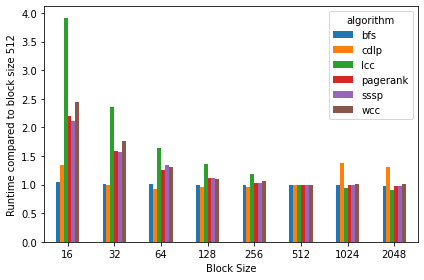

In [6]:
normalized = data.loc["graph500-24"] / data.loc["graph500-24", 512]


visualize = normalized
visualize.plot.bar()
plt.xlabel("Block Size")
plt.ylabel("Runtime compared to block size 512")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig(base_path + "block-sizes-analytics.png")

In [7]:
normalized = data.loc["uniform-24"] / data.loc["uniform-24", 256]


visualize = normalized
visualize.plot.bar()

KeyError: 256

#### Observation

There is no trend that indicates block sizes between 256 and 1024 have major influence on the performance of analytical algorithms.

Below 256 multiple analytical algoritms loose performance. 

## Inserts

In [9]:
sortledton_block_sizeonly = "(hostname == 'scyper21' or hostname == 'scyper22') and library == 'sortledton.3' and graph in ('graph500-22', 'graph500-24', 'graph500-26', 'uniform-24') and block_size != -1"

edges_per_graph = pd.DataFrame({
    "graph": ["friendster", "dota-league", "graph500-22", 
              "graph500-24", "graph500-26", "uniform-22", 
              "uniform-24", "uniform-26"
              ],
    "edges": [1806067135, 50870313, 64155735, 260379520, 1051922853, 64155735, 260379520, 1051922853]
})

data = common.import_gfe("View_Inserts").query(sortledton_block_sizeonly).copy() # data from the experiments
data["build_frequency"].fillna(pd.Timedelta(0), inplace=True) # replace NaT with 0, otherwise the records are ignored in the group by
data = data.merge(edges_per_graph, on="graph")
data["edges_per_second"] = data["edges"] / data["completion_time_secs"]

data_grouped = data.groupby(["graph", "block_size"]) \
    .agg(edges_per_second=("edges_per_second", "median"), count=("edges_per_second", "count"))
#data = data.unstack("algorithm")[("completion_time")]
data_grouped

edges_per_second  count
graph       block_size                         
graph500-22 512             4.126019e+06      2
graph500-24 16              1.663785e+06      6
            32              3.561707e+06      6
            64              4.231400e+06      6
            128             4.352898e+06      5
            256             4.268190e+06      5
            512             3.836104e+06      7
            1024            3.175241e+06      5
            2048            2.245332e+06      5
graph500-26 512             3.586790e+06      2
uniform-24  512             4.737711e+06      3

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, '16'),
  Text(1, 0, '32'),
  Text(2, 0, '64'),
  Text(3, 0, '128'),
  Text(4, 0, '256'),
  Text(5, 0, '512'),
  Text(6, 0, '1024'),
  Text(7, 0, '2048')])

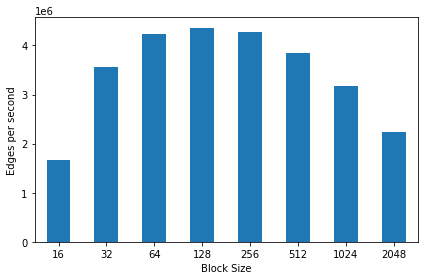

In [11]:
visualize = data_grouped.loc["graph500-24"].copy()
visualize = visualize.drop("count", axis=1)
p = visualize.plot.bar()
plt.xlabel("Block Size")
plt.ylabel("Edges per second")
plt.xticks(rotation=0)
p.get_legend().remove()
plt.tight_layout()
plt.savefig(base_path + "block-sizes-insertions.png")
plt.xticks(rotation=0)

(array([0, 1, 2]), [Text(0, 0, '256'), Text(1, 0, '512'), Text(2, 0, '1024')])

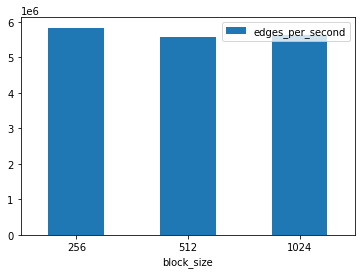

In [43]:
visualize = data_grouped.loc["uniform-24"].copy()
visualize = visualize.drop("count", axis=1)
p = visualize.plot.bar()
plt.xticks(rotation=0)

#### Observation

For uniform graphs the block size has no influence on the insertions performance. 
For power-law graphs we see that blocks of sizes of 128 or 256 are best.

#### Explanation

For uniform graphs we do not see the use of many/any blocks because the adjacency set sizes are mostly below.
For power-law graphs small block sizes are better because either finding the correct block is cheaper if performed with skip-list jumps than binary search or/xor there is less data to move, e.g. in the GC.
For too small block sizes we see more random jumps to check the skip list and more memory allocation overhead.

## Result

We run a wider range of block size parameters to
  (1) find the limit when it influences analytical performance.
  (2) find the best block size for insertions

There is no need to run with blocks bigger than 1024 because we do expect insertion performance to decrease without winning analytical performance.
  
We start with the parameters: 8, 32, 64 and 128 on the same graphs.

We find that 512 is the best block size because it is safe to state that analytical algorithms do not suffer and we see good insertion performance.

## Open Question

What happens to the storage size of the data structure?
 We already observed that a block size of 32 cannot be loaded into memory for graph500-26.
What about LCC?